# Electric consumption model

- Using `2009 RECS Survey Data` availible [here](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv)
- This file is available in [GitHub](https://github.com/arminnorouzi/zestyAI)

**Table of content**
- Data Analysis and preparation
- Tree-based model - further cleaning data and outlier
- Modeling using deep neural network (TensorFlow)
- LASSO regression for feature selection
- Tree-based model based on selected features
- Deep neural network based on selected features
- Results comparison and further improvement

## Data Analysis and prepration

In [67]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt

In [68]:
# Read in the 2009 RECS Survey dataset
data = pd.read_csv("https://raw.githubusercontent.com/arminnorouzi/zestyAI/main/data/recs2009_public.csv")
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


In [69]:
# Check information of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(50), int64(885), object(5)
memory usage: 86.7+ MB


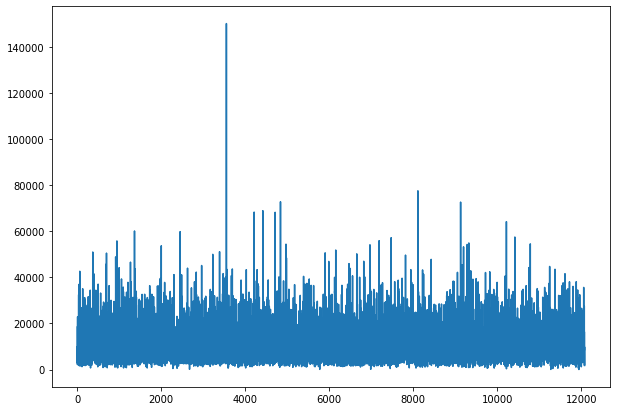

In [70]:
# Let's plot KWH first
plt.figure(figsize=(10, 7))
plt.plot(data['KWH'], label="Electric Consumption")


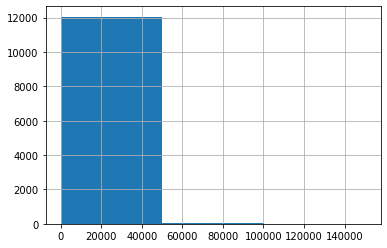

In [71]:
# histogram of data
hist = data['KWH'].hist(bins=3)

It seems we have some outlier!


In [72]:
data.columns.values.tolist()

['DOEID',
 'REGIONC',
 'DIVISION',
 'REPORTABLE_DOMAIN',
 'TYPEHUQ',
 'NWEIGHT',
 'HDD65',
 'CDD65',
 'HDD30YR',
 'CDD30YR',
 'Climate_Region_Pub',
 'AIA_Zone',
 'METROMICRO',
 'UR',
 'KOWNRENT',
 'CONDCOOP',
 'YEARMADE',
 'YEARMADERANGE',
 'OCCUPYYRANGE',
 'CONVERSION',
 'ORIG1FAM',
 'LOOKLIKE',
 'NUMFLRS',
 'NUMAPTS',
 'WALLTYPE',
 'ROOFTYPE',
 'STUDIO',
 'NAPTFLRS',
 'STORIES',
 'TYPEHUQ4',
 'BEDROOMS',
 'NCOMBATH',
 'NHAFBATH',
 'OTHROOMS',
 'TOTROOMS',
 'CELLAR',
 'CRAWL',
 'CONCRETE',
 'BASEFIN',
 'FINBASERMS',
 'BASEHEAT',
 'BASEHT2',
 'PCTBSTHT',
 'BASECOOL',
 'BASECL2',
 'PCTBSTCL',
 'BASEUSE',
 'ATTIC',
 'ATTICFIN',
 'FINATTRMS',
 'ATTCHEAT',
 'ATTCHT2',
 'PCTATTHT',
 'ATTCCOOL',
 'ATTCCL2',
 'PCTATTCL',
 'ATTICUSE',
 'PRKGPLC1',
 'SIZEOFGARAGE',
 'GARGLOC',
 'GARGHEAT',
 'GARGCOOL',
 'PRKGPLC2',
 'SIZEOFDETACH',
 'OUTLET',
 'ZKOWNRENT',
 'ZCONDCOOP',
 'ZYEARMADE',
 'ZYEARMADERANGE',
 'ZOCCUPYYRANGE',
 'ZCONVERSION',
 'ZORIG1FAM',
 'ZLOOKLIKE',
 'ZNUMFLRS',
 'ZNUMAPTS',
 'ZWA

In [73]:
# Let's find colum name of output first

output_index_no = data.columns.get_loc('KWH')
output_index_no

839

In [74]:
# Create a new dataset with features and output


data1 = data.iloc[:, 0:output_index_no+1]
data1.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,TOTUSQFT,TOTCSQFT,TOTUCSQFT,ZTOTSQFT,ZTOTSQFT_EN,ZTOTHSQFT,ZTOTUSQFT,ZTOTCSQFT,ZTOTUCSQFT,KWH
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,1118,3958,1118,0,0,0,0,0,0,18466
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,400,2736,400,1,1,1,1,1,1,5148
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,0,264,264,0,0,0,0,0,0,2218
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,400,1623,400,0,0,0,0,0,0,10015
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,637,0,1912,0,0,0,0,0,0,2869


In [75]:
# Let's check out data types
data1.dtypes.values.tolist()

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dt

We have some `o` (object) and `float64` data type amoung our features. Let's see which one has a different data type. 




In [76]:
data1.select_dtypes('float64')

,NWEIGHT,NUMCORDS
0,2471.68,-2.0
1,8599.17,-2.0
2,8969.92,-2.0
3,18003.64,-2.0
4,5999.61,-2.0
...,...,...
12078,10219.80,-2.0
12079,8689.07,-2.0
12080,4697.21,-2.0
12081,13155.68,-2.0


In [77]:
data1["NUMCORDS"] = data1['NUMCORDS'].astype('int64')
data1["NUMCORDS"]

0       -2
1       -2
2       -2
3       -2
4       -2
        ..
12078   -2
12079   -2
12080   -2
12081   -2
12082   -2
Name: NUMCORDS, Length: 12083, dtype: int64

In [78]:
data1.select_dtypes('O')

,METROMICRO,UR,NOCRCASH,NKRGALNC
0,METRO,U,-2,-2
1,METRO,U,-2,-2
2,METRO,U,-2,-2
3,METRO,U,-2,-2
4,METRO,U,-2,-2
...,...,...,...,...
12078,METRO,U,-2,-2
12079,METRO,U,-2,-2
12080,METRO,U,-2,-2
12081,METRO,U,-2,-2


In [79]:
# data1["NOCRCASH"] = data1['NOCRCASH'].astype('int64')
# data1["NOCRCASH"]

# I got this error using above code: invalid literal for int() with base 10: '.'
# It seems we have some row with `.`- let's remove them

data1 = data1[data1["NOCRCASH"] != '.']

In [80]:
data1["NOCRCASH"] = data1['NOCRCASH'].astype('int64')
data1["NOCRCASH"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0       -2
1       -2
2       -2
3       -2
4       -2
        ..
12078   -2
12079   -2
12080   -2
12081   -2
12082   -2
Name: NOCRCASH, Length: 12081, dtype: int64

In [81]:
data1 = data1[data1["NKRGALNC"] != '.']

data1["NKRGALNC"] = data1['NKRGALNC'].astype('int64')
data1["NKRGALNC"]

0       -2
1       -2
2       -2
3       -2
4       -2
        ..
12078   -2
12079   -2
12080   -2
12081   -2
12082   -2
Name: NKRGALNC, Length: 12081, dtype: int64

By checking features it seems we have imputation in some of the features and all of them started with `z` such as `KOWNRENT` and new variable defiened as `zKOWNRENT` which indicated whether it is imputated or not. 

- We need to deal with catagorical data `METROMICRO`	`UR`- We can use OneHotEncoder or get_dummies (pandas)

In [82]:
# Turn all categories into numbers
data2 = pd.get_dummies(data1)
data2.head() # view the converted columns

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,ZTOTHSQFT,ZTOTUSQFT,ZTOTCSQFT,ZTOTUCSQFT,KWH,METROMICRO_METRO,METROMICRO_MICRO,METROMICRO_NONE,UR_R,UR_U
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,0,0,0,0,18466,1,0,0,0,1
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,1,1,1,1,5148,1,0,0,0,1
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,0,0,0,0,2218,1,0,0,0,1
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,0,0,0,0,10015,1,0,0,0,1
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,0,0,0,0,2869,1,0,0,0,1


## Tree-based model

### Original features

In [83]:
# All features

FS = data2.drop(columns=['KWH'])
FS.head()


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,ZTOTSQFT_EN,ZTOTHSQFT,ZTOTUSQFT,ZTOTCSQFT,ZTOTUCSQFT,METROMICRO_METRO,METROMICRO_MICRO,METROMICRO_NONE,UR_R,UR_U
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,0,0,0,0,0,1,0,0,0,1
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,1,1,1,1,1,1,0,0,0,1
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,0,0,0,0,0,1,0,0,0,1
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,0,0,0,0,0,1,0,0,0,1
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,0,0,0,0,0,1,0,0,0,1


In [84]:
# Output 

KWH = data2['KWH']
print(KWH)

0        18466
1         5148
2         2218
3        10015
4         2869
         ...  
12078     7647
12079     1813
12080     9834
12081     4800
12082     1764
Name: KWH, Length: 12081, dtype: int64


In [85]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(FS, 
                                                    KWH, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

### Regression Tree model

- Let's try it without normalization and with simple tree-based model as it can handle value without feature engineering

In [86]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor


regr_tree = DecisionTreeRegressor(max_depth=5) 

regr_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

Text(0.5, 0, 'Prediction')

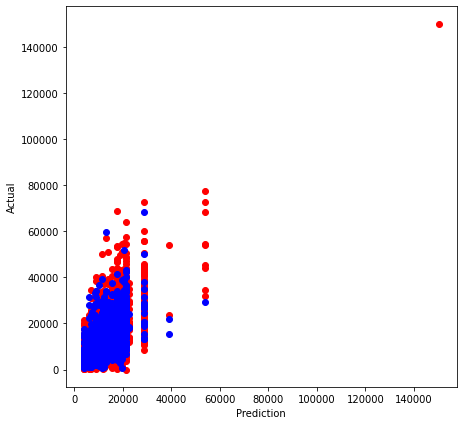

In [87]:
# Test model
y_tr = regr_tree.predict(X_train)
y_ts = regr_tree.predict(X_test)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr,y_train, 'or', label="training data")
plt.plot(y_ts,y_test, 'ob', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

**Evaluation**

In [88]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

print(f"Maximum error on training set: {max_error(y_train, y_tr)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts)}")


Maximum error on training set: 51232.11664779162
Meanabsolute error on training set: 3855.70888909167
Mean squared error on training set: 29995397.345980164
Maximum error on training set: 46624.09056603773
Meanabsolute error on training set: 3863.3532900828554
Mean squared error on training set: 29965248.75899708


Maximum error on training set: 15335.563063063064
Meanabsolute error on training set: 1119.340575946831
Mean squared error on training set: 3896335.2747777067
Maximum error on training set: 47560.0
Meanabsolute error on training set: 4252.258910025405
Mean squared error on training set: 41129120.17969077


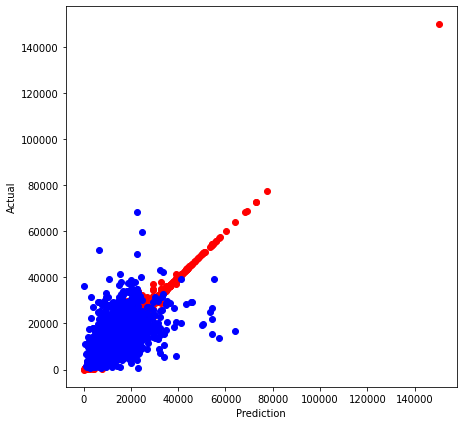

In [89]:
# very large prediciton error- lets try better model

regr_tree_2 = DecisionTreeRegressor(max_depth=15) 

regr_tree_2.fit(X_train, y_train)

# Test model
y_tr_2 = regr_tree_2.predict(X_train)
y_ts_2 = regr_tree_2.predict(X_test)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_2,y_train, 'or', label="training data")
plt.plot(y_ts_2,y_test, 'ob', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_2)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_2)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_2)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_2)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_2)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_2)}")

### Removing Outlier

Maximum error on training set: 15629.8
Meanabsolute error on training set: 1121.9070909051113
Mean squared error on training set: 3800508.058596325
Maximum error on training set: 53379.0
Meanabsolute error on training set: 4323.767587798728
Mean squared error on training set: 40897818.79510044


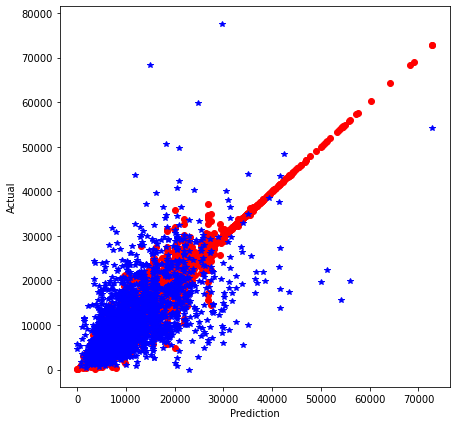

In [90]:
# model is improved but Let's remove an obvous outlier based on this figure and then use the same model

data3 = data2[data2['KWH'] < 100000]

# All features

FS = data3.drop(columns=['KWH'])


# Output 

KWH = data3['KWH']



X_train, X_test, y_train, y_test = train_test_split(FS, 
                                                    KWH, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

regr_tree_3 = DecisionTreeRegressor(max_depth=15) 

regr_tree_3.fit(X_train, y_train)

# Test model
y_tr_3 = regr_tree_3.predict(X_train)
y_ts_3 = regr_tree_3.predict(X_test)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_3,y_train, 'or', label="training data")
plt.plot(y_ts_3,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_3)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_3)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_3)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_3)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_3)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_3)}")

In [91]:
# We have better model on training data but not in test data- let's normalize dataset

### Preprocessing data (normalization and standardization)

In [109]:
from sklearn.preprocessing import MinMaxScaler

# Create minmax 
ct = MinMaxScaler()

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [93]:
# Check the same tree model

Maximum error on training set: 15629.8
Meanabsolute error on training set: 1121.9070909051113
Mean squared error on training set: 3800508.058596325
Maximum error on training set: 50347.0
Meanabsolute error on training set: 4287.486408417557
Mean squared error on training set: 40504524.67196601


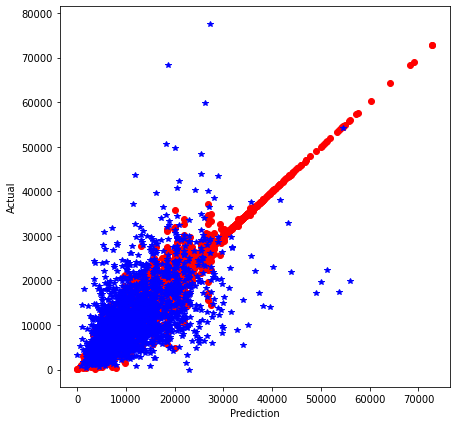

In [94]:

regr_tree_4 = DecisionTreeRegressor(max_depth=15) 

regr_tree_4.fit(X_train_normal, y_train)

# Test model
y_tr_4 = regr_tree_4.predict(X_train_normal)
y_ts_4 = regr_tree_4.predict(X_test_normal)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_4,y_train, 'or', label="training data")
plt.plot(y_ts_4,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_4)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_4)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_4)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_4)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_4)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_4)}")

In [95]:
# It was kind of obvous from start that normalization has no effect on tree-based modeling- As we have relitively large data-based, let's try deep network

## Modeling - Deep Neural Network

- I used Google Colab for running this notebook (TF 2.8.0)

In [96]:
import tensorflow as tf
print(tf.__version__) # check the version (should be 2.x+)

2.8.0


Model: "My_NN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Dense)         (None, 1)                 843       
                                                                 
 Hidden_layer_1 (Dense)      (None, 40)                80        
                                                                 
 Hidden_layer_2 (Dense)      (None, 40)                1640      
                                                                 
 Hidden_layer_3 (Dense)      (None, 40)                1640      
                                                                 
 Output_layer (Dense)        (None, 1)                 41        
                                                                 
Total params: 4,244
Trainable params: 4,244
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
302/302 [==============================] 

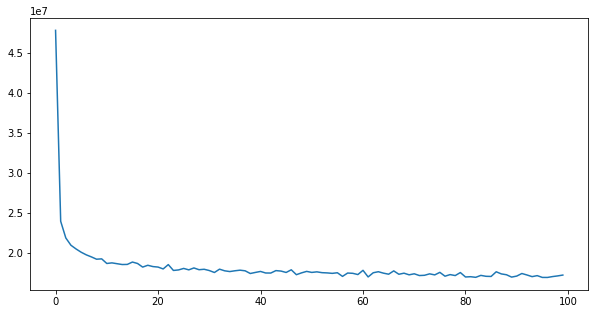

In [115]:
# Set a seed for reproducing purpuse
tf.random.set_seed(42)

# Create model
KWH_model = tf.keras.Sequential([
                      tf.keras.layers.Dense(1, input_shape = [842], name ="Input_layer"),
                      tf.keras.layers.Dense(40, activation="relu", name ="Hidden_layer_1"),
                      tf.keras.layers.Dense(40, activation="relu", name ="Hidden_layer_2"),
                      tf.keras.layers.Dense(40, activation="relu", name ="Hidden_layer_3"),
                      tf.keras.layers.Dense(1, name = "Output_layer")
                      ], name = "My_NN_model")

# Model Summary
KWH_model.summary()

# Compile model
KWH_model.compile(loss=tf.keras.losses.mse, # mse is short for mean squared error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # Adam is my first choice
              metrics=["mse"])

history = KWH_model.fit(X_train_normal,y_train, epochs = 100,verbose = 1)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])

Maximum error on training set: 41276.2568359375
Meanabsolute error on training set: 2947.0509960856657
Mean squared error on training set: 16606019.588506913
Maximum error on training set: 32991.29296875
Meanabsolute error on training set: 3175.8664894356634
Mean squared error on training set: 19264734.531487476


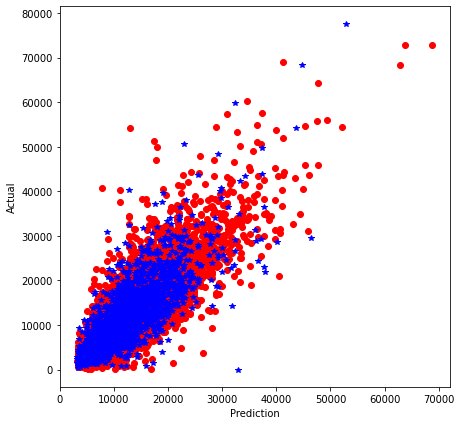

In [116]:
y_tr_5 = KWH_model.predict(X_train_normal)
y_ts_5 = KWH_model.predict(X_test_normal)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_5,y_train, 'or', label="training data")
plt.plot(y_ts_5,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_5)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_5)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_5)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_5)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_5)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_5)}")

In [117]:
# it seems we have a robust prediction but still need more work to make this model accurate

Model: "My_NN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Dense)         (None, 1)                 843       
                                                                 
 Hidden_layer_1 (Dense)      (None, 32)                64        
                                                                 
 Hidden_layer_2 (Dense)      (None, 64)                2112      
                                                                 
 Hidden_layer_4 (Dense)      (None, 128)               8320      
                                                                 
 Hidden_layer_5 (Dense)      (None, 64)                8256      
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 19,660
Trainable params: 19,660
Non-train

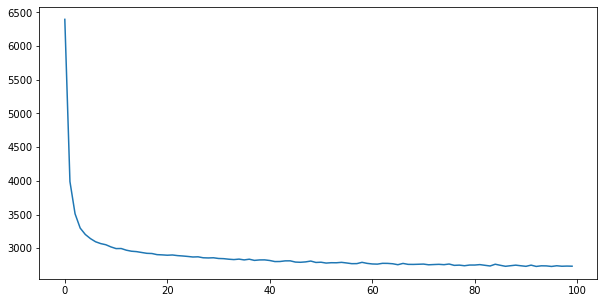

In [119]:
# Set random seed for reproducing purpuse
tf.random.set_seed(42)

# Create model
KWH_model2 = tf.keras.Sequential([
                      tf.keras.layers.Dense(1, input_shape = [842], name ="Input_layer"),
                      tf.keras.layers.Dense(32, activation="relu", name ="Hidden_layer_1"),
                      tf.keras.layers.Dense(64, activation="relu", name ="Hidden_layer_2"),
                      tf.keras.layers.Dense(128, activation="relu", name ="Hidden_layer_4"),
                      tf.keras.layers.Dense(64, activation="relu", name ="Hidden_layer_5"),
                      tf.keras.layers.Dense(1, name = "Output_layer")
                      ], name = "My_NN_model")

# Model Summary
KWH_model2.summary()

# Compile model
KWH_model2.compile(loss=tf.keras.losses.mae, # mse is short for mean squared error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam is my first choice
              metrics=["mae"])

history = KWH_model2.fit(X_train_normal,y_train, epochs = 100,verbose = 1)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])

Maximum error on training set: 42986.4189453125
Meanabsolute error on training set: 2690.106112334902
Mean squared error on training set: 17556852.48558087
Maximum error on training set: 34994.734375
Meanabsolute error on training set: 2863.7454131675872
Mean squared error on training set: 18589317.49079052


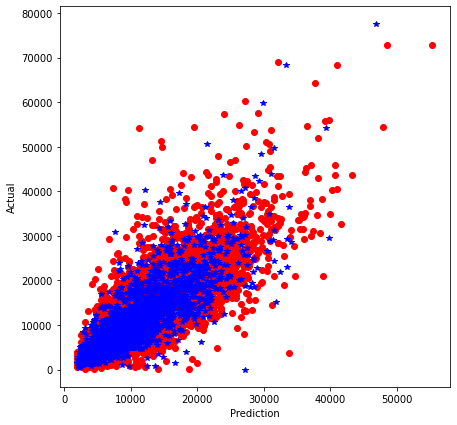

In [120]:
y_tr_6 = KWH_model2.predict(X_train_normal)
y_ts_6 = KWH_model2.predict(X_test_normal)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_6,y_train, 'or', label="training data")
plt.plot(y_ts_6,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_6)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_6)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_6)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_6)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_6)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_6)}")

It seems we have better model by increasing number of layer and changing loss function to MAE and decreasing learning rate

Adding more layer suggest that we need more feature engineering-- As LASSO regression model is able to remove unneccessary features, I would like to try it as my last try to improve model

## LASSO regression for feature selection

Trying to minimize the cost function, Lasso regression will automatically select those features that are useful, discarding the useless or redundant features. In Lasso regression, discarding a feature will make its coefficient equal to 0.

Maximum error on training set: 40745.1995925087
Meanabsolute error on training set: 3047.295153142451
Mean squared error on training set: 19987277.096182533
Maximum error on training set: 37846.242016248645
Meanabsolute error on training set: 3036.2952064065616
Mean squared error on training set: 19794928.214807082


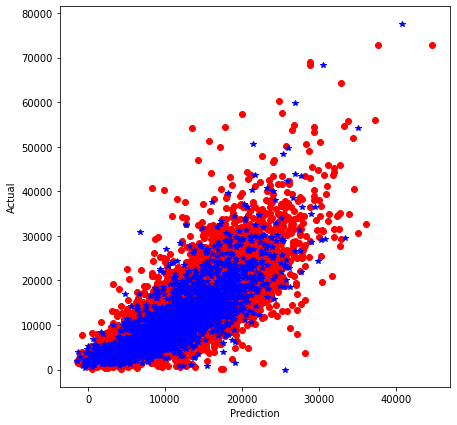

In [125]:
from sklearn import linear_model

KWH_model_lasso = linear_model.Lasso(alpha=10)
KWH_model_lasso.fit(X_train_normal, y_train)

y_tr_7 = KWH_model_lasso.predict(X_train_normal)
y_ts_7 = KWH_model_lasso.predict(X_test_normal)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_7,y_train, 'or', label="training data")
plt.plot(y_ts_7,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_7)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_7)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_7)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_7)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_7)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_7)}")

In [128]:
KWH_model_lasso.coef_

array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.81834457e+03,  0.00000000e+00,  2.74749671e+03,  0.00000000e+00,
        0.00000000e+00,  4.10368597e+03,  1.27503037e+03,  0.00000000e+00,
        0.00000000e+00, -1.65450363e+02, -0.00000000e+00, -7.56437742e+02,
       -0.00000000e+00,  0.00000000e+00,  1.66672199e+02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.92849063e+02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.85012715e+01,  3.72496658e+02,
        0.00000000e+00,  2.62510396e+03,  0.00000000e+00,  0.00000000e+00,
        2.87574077e+03, -0.00000000e+00,  0.00000000e+00, -1.05104747e+02,
       -9.23899718e+01, -0.00000000e+00, -1.70928187e+02, -0.00000000e+00,
        0.00000000e+00, -3.54824551e+02, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -

As it has been seen, some coefficients are zero. Now I want to remove those values from the dataframe. I will add this array to the dataframe. Then remove those columns which have zero in that specific row. 

In [132]:
# Lets add these coeffienet to datafrane
arr = KWH_model_lasso.coef_
data_to_append = {}
for i in range(len(FS.columns)):
    data_to_append[FS.columns[i]] = arr[i]
FS_candidate = FS.append(data_to_append, ignore_index = True)

In [133]:
FS_candidate.head()


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,ZTOTSQFT_EN,ZTOTHSQFT,ZTOTUSQFT,ZTOTCSQFT,ZTOTUCSQFT,METROMICRO_METRO,METROMICRO_MICRO,METROMICRO_NONE,UR_R,UR_U
0,1.0,2.0,4.0,12.0,2.0,2471.68,4742.0,1080.0,4953.0,1271.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2.0,4.0,10.0,26.0,2.0,8599.17,2662.0,199.0,2688.0,143.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,3.0,1.0,1.0,1.0,5.0,8969.92,6233.0,505.0,5741.0,829.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4.0,2.0,3.0,7.0,2.0,18003.64,6034.0,672.0,5781.0,868.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5.0,1.0,1.0,1.0,3.0,5999.61,5388.0,702.0,5313.0,797.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [136]:
 FS_candidate.tail()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,ZTOTSQFT_EN,ZTOTHSQFT,ZTOTUSQFT,ZTOTCSQFT,ZTOTUCSQFT,METROMICRO_METRO,METROMICRO_MICRO,METROMICRO_NONE,UR_R,UR_U
12076,12080.0,3.0,7.0,21.0,4.000000,8689.07,2085.000000,2844.0,2520.0,2286.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,1.0
12077,12081.0,2.0,4.0,10.0,2.000000,4697.21,7935.000000,472.0,8074.0,600.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,1.0
12078,12082.0,4.0,8.0,23.0,2.000000,13155.68,5834.000000,770.0,5989.0,957.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,1.0
12079,12083.0,4.0,10.0,26.0,2.000000,7703.43,2806.000000,124.0,2859.0,139.000000,...,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.0,0.000000,1.0
12080,-0.0,-0.0,0.0,0.0,-1818.344568,0.00,2747.496707,0.0,0.0,4103.685969,...,0.0,0.0,0.0,0.0,0.0,-273.243129,0.0,0.0,1032.961772,-0.0


In [157]:
# No we can drop columns where coefficient of LASSO regression are zero

# Let's put coeffienet inside the database

selected_features = []
for column_headers in FS_candidate.columns: 
  if FS_candidate.iloc[12080][column_headers] < -0.1:
    selected_features.append(column_headers)
  elif FS_candidate.iloc[12080][column_headers] > 0.1:
    selected_features.append(column_headers)


In [160]:
len(selected_features) # Now we have only 180 features to check

180

In [167]:
FS_selected = FS_candidate[selected_features]
FS_selected.tail()

,TYPEHUQ,HDD65,CDD30YR,Climate_Region_Pub,CONDCOOP,YEARMADERANGE,ORIG1FAM,WALLTYPE,STORIES,TYPEHUQ4,...,RETIREPY,SSINCOME,CASHBEN,INVESTMT,RGLRPAY,MONEYPY,POVERTY150,TOTCSQFT,METROMICRO_METRO,UR_R
12076,4.000000,2085.000000,2286.000000,2.000000,-2.000000,5.000000,-2.000000,1.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,9.000000,0.000000,502.000000,1.000000,0.000000
12077,2.000000,7935.000000,600.000000,1.000000,-2.000000,6.000000,-2.000000,3.000000,31.000000,-2.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,24.000000,0.000000,4181.000000,1.000000,0.000000
12078,2.000000,5834.000000,957.000000,1.000000,-2.000000,1.000000,-2.000000,1.000000,10.000000,-2.000000,...,1.000000,0.000000,0.000000,0.00000,0.00000,4.000000,1.000000,518.000000,1.000000,0.000000
12079,2.000000,2806.000000,139.000000,5.000000,-2.000000,1.000000,-2.000000,2.000000,10.000000,-2.000000,...,0.000000,0.000000,0.000000,1.00000,0.00000,7.000000,0.000000,0.000000,1.000000,0.000000
12080,-1818.344568,2747.496707,4103.685969,1275.030372,-165.450363,-756.437742,166.672199,-792.849063,-58.501272,372.496658,...,-480.121031,341.339481,256.848827,-145.77196,29.91926,401.095272,248.463387,9686.363951,-273.243129,1032.961772


In [172]:
# We don't need last row anymore
FS_selected = FS_selected[:-1]

In [173]:
FS_selected.tail()

,TYPEHUQ,HDD65,CDD30YR,Climate_Region_Pub,CONDCOOP,YEARMADERANGE,ORIG1FAM,WALLTYPE,STORIES,TYPEHUQ4,...,RETIREPY,SSINCOME,CASHBEN,INVESTMT,RGLRPAY,MONEYPY,POVERTY150,TOTCSQFT,METROMICRO_METRO,UR_R
12075,2.0,7671.0,451.0,1.0,-2.0,5.0,-2.0,3.0,10.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,893.0,1.0,0.0
12076,4.0,2085.0,2286.0,2.0,-2.0,5.0,-2.0,1.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,502.0,1.0,0.0
12077,2.0,7935.0,600.0,1.0,-2.0,6.0,-2.0,3.0,31.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,24.0,0.0,4181.0,1.0,0.0
12078,2.0,5834.0,957.0,1.0,-2.0,1.0,-2.0,1.0,10.0,-2.0,...,1.0,0.0,0.0,0.0,0.0,4.0,1.0,518.0,1.0,0.0
12079,2.0,2806.0,139.0,5.0,-2.0,1.0,-2.0,2.0,10.0,-2.0,...,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0


In [175]:
FS_selected.info

<bound method DataFrame.info of        TYPEHUQ   HDD65  CDD30YR  Climate_Region_Pub  CONDCOOP  YEARMADERANGE  \
0          2.0  4742.0   1271.0                 4.0      -2.0            7.0   
1          2.0  2662.0    143.0                 5.0      -2.0            6.0   
2          5.0  6233.0    829.0                 1.0      -2.0            3.0   
3          2.0  6034.0    868.0                 1.0      -2.0            5.0   
4          3.0  5388.0    797.0                 1.0       1.0            5.0   
...        ...     ...      ...                 ...       ...            ...   
12075      2.0  7671.0    451.0                 1.0      -2.0            5.0   
12076      4.0  2085.0   2286.0                 2.0      -2.0            5.0   
12077      2.0  7935.0    600.0                 1.0      -2.0            6.0   
12078      2.0  5834.0    957.0                 1.0      -2.0            1.0   
12079      2.0  2806.0    139.0                 5.0      -2.0            1.0   

       

## Regression tree with selected features

Maximum error on training set: 15144.9125
Meanabsolute error on training set: 1054.4280296183608
Mean squared error on training set: 3394103.86149572
Maximum error on training set: 43867.0
Meanabsolute error on training set: 4179.08719292613
Mean squared error on training set: 37719662.34362897


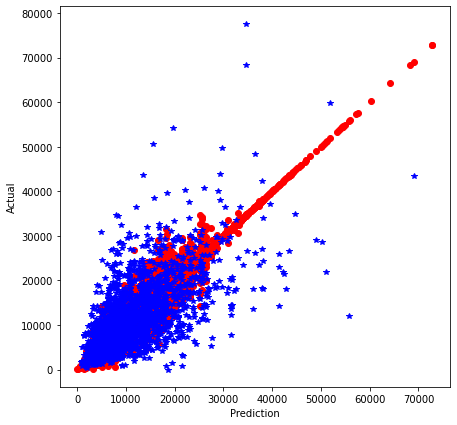

In [176]:


X_train, X_test, y_train, y_test = train_test_split(FS_selected, 
                                                    KWH, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

regr_tree_8 = DecisionTreeRegressor(max_depth=15) 

regr_tree_8.fit(X_train, y_train)

# Test model
y_tr_8 = regr_tree_8.predict(X_train)
y_ts_8 = regr_tree_8.predict(X_test)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_8,y_train, 'or', label="training data")
plt.plot(y_ts_8,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_8)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_8)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_8)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_8)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_8)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_8)}")

## Deep Network with selected features

In [177]:
# Create minmax 
ct = MinMaxScaler()

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Model: "My_NN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Dense)         (None, 1)                 181       
                                                                 
 Hidden_layer_1 (Dense)      (None, 32)                64        
                                                                 
 Hidden_layer_2 (Dense)      (None, 64)                2112      
                                                                 
 Hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 Output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 4,470
Trainable params: 4,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
302/302 [==============================] 

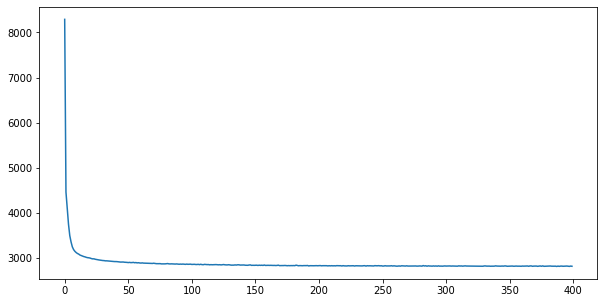

In [187]:
# Set random seed for reproducing purpuse
tf.random.set_seed(42)

# Create model
KWH_model3 = tf.keras.Sequential([
                      tf.keras.layers.Dense(1, input_shape = [180], name ="Input_layer"),
                      tf.keras.layers.Dense(32, activation="relu", name ="Hidden_layer_1"),
                      tf.keras.layers.Dense(64, activation="relu", name ="Hidden_layer_2"),
                      tf.keras.layers.Dense(32, activation="relu", name ="Hidden_layer_3"),
                      tf.keras.layers.Dense(1, name = "Output_layer")
                      ], name = "My_NN_model")

# Model Summary
KWH_model3.summary()

# Compile model
KWH_model3.compile(loss=tf.keras.losses.mae, # mse is short for mean squared error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam is my first choice
              metrics=["mae"])

history = KWH_model3.fit(X_train_normal,y_train, epochs = 400,verbose = 1)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])

Maximum error on training set: 42390.9267578125
Meanabsolute error on training set: 2809.7849791318376
Mean squared error on training set: 18920490.79139619
Maximum error on training set: 35983.96875
Meanabsolute error on training set: 2821.8549934033526
Mean squared error on training set: 18572146.704485547


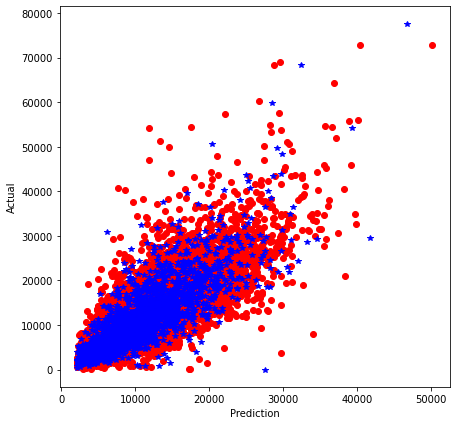

In [188]:
y_tr_9 = KWH_model3.predict(X_train_normal)
y_ts_9 = KWH_model3.predict(X_test_normal)


# ploting
plt.figure(figsize=(7, 7))
plt.plot(y_tr_9,y_train, 'or', label="training data")
plt.plot(y_ts_9,y_test, '*b', label="testing data")
plt.ylabel('Actual')
plt.xlabel('Prediction')

print(f"Maximum error on training set: {max_error(y_train, y_tr_9)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_train, y_tr_9)}")
print(f"Mean squared error on training set: {mean_squared_error(y_train, y_tr_9)}")


print(f"Maximum error on training set: {max_error(y_test, y_ts_9)}")
print(f"Meanabsolute error on training set: {mean_absolute_error(y_test, y_ts_9)}")
print(f"Mean squared error on training set: {mean_squared_error(y_test, y_ts_9)}")

## Results comparison

| Method | Number of Features/ Learnable paramters | MSE | MAE |
| --- | --- | --- | --- |
| Best Regression Tree | 842 | 4323.8 | 40897818.9 | 
| Best Deep Network | 842/ 19,660 | 2863.74  |18589317.4 | 
| Best Regression Tree | 180 | 4179.08 |  37719662.3 | 
| Best Deep Network | 180/ 4,470 | 18572146.7| 18572146.7 | 

Here is the summary:
- By using LASSO method for feature selection, I reduced the feature set by 4.6 times less than the full feature set
- FS selection has effect in reducing Deep neural network where there is the same results with a significantly simpler model
- More investigation requires in feature analysis to make the model better
- Normalizing output might be helpful